<a href="https://colab.research.google.com/github/ybii22/Machine-Learning/blob/main/week%208%20-%2016/Chapter_7_%E2%80%93_Ensemble_Learning_and_Random_Forests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "ensembles"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# **Voting Classifiers**

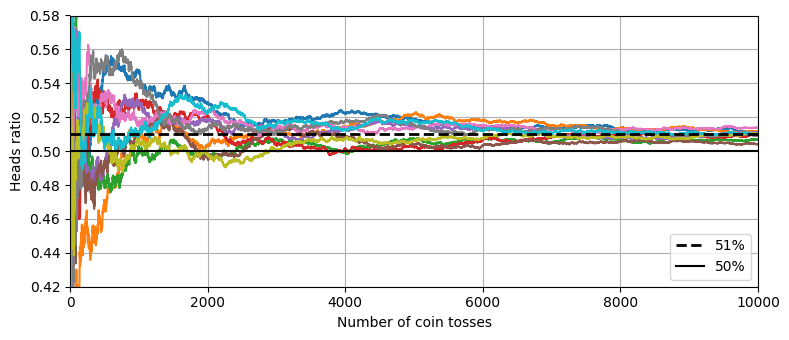

In [2]:
import matplotlib.pyplot as plt
import numpy as np

heads_proba = 0.51
np.random.seed(42)
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads = coin_tosses.cumsum(axis=0)
cumulative_heads_ratio = cumulative_heads / np.arange(1, 10001).reshape(-1, 1)

plt.figure(figsize=(8, 3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
plt.grid()
save_fig("law_of_large_numbers_plot")
plt.show()

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()
voting_clf = VotingClassifier(
estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [7]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, "Accuracy:", accuracy_score(y_test, y_pred))


LogisticRegression Accuracy: 1.0
RandomForestClassifier Accuracy: 1.0
SVC Accuracy: 1.0
VotingClassifier Accuracy: 1.0


# **Bagging and Pasting in Scikit-Learn**

In [12]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            max_samples=100, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1, random_state=42)

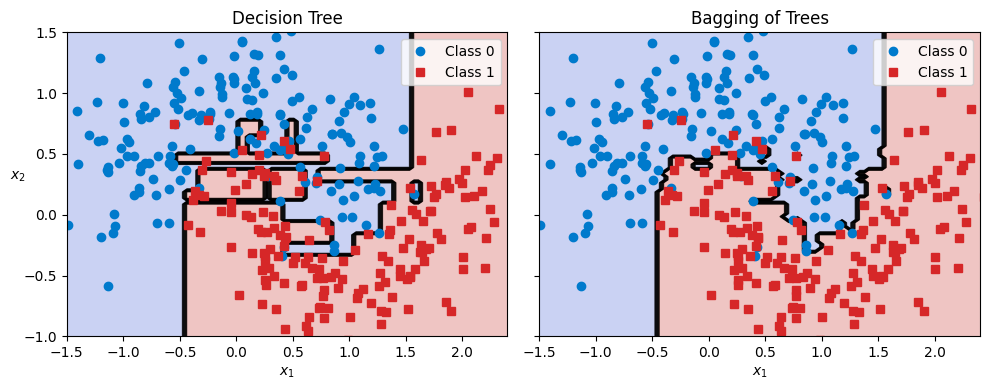

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split

# Fungsi simpan gambar (opsional)
def save_fig(name, tight_layout=True):
    plt.savefig(f"{name}.png", dpi=300, bbox_inches='tight' if tight_layout else None)

# Fungsi visualisasi decision boundary
def plot_decision_boundary(clf, X, y, alpha=1.0):
    axes = [-1.5, 2.4, -1, 1.5]
    x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                         np.linspace(axes[2], axes[3], 100))
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)

    # Plot contour dan scatter
    plt.contourf(x1, x2, y_pred, alpha=0.3 * alpha, cmap='coolwarm')  # warna background
    plt.contour(x1, x2, y_pred, colors="k", linewidths=1, alpha=0.8 * alpha)

    colors = ["#007acc", "#d62728"]  # biru dan merah
    markers = ("o", "s")  # lingkaran dan kotak
    for idx in (0, 1):
        plt.plot(X[:, 0][y == idx], X[:, 1][y == idx],
                 color=colors[idx], marker=markers[idx], linestyle="none", label=f"Class {idx}")
    plt.axis(axes)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$", rotation=0)
    plt.legend()

# === 1. Dataset dummy 2D (gantilah ini jika kamu sudah punya X_train dan y_train) ===
X, y = make_moons(n_samples=500, noise=0.3, random_state=42)
X_train, _, y_train, _ = train_test_split(X, y, test_size=0.3, random_state=42)

# === 2. Model ===
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=50, random_state=42
)
bag_clf.fit(X_train, y_train)

# === 3. Visualisasi ===
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plot_decision_boundary(tree_clf, X_train, y_train)
plt.title("Decision Tree")

plt.sca(axes[1])
plot_decision_boundary(bag_clf, X_train, y_train)
plt.title("Bagging of Trees")
plt.ylabel("")

save_fig("decision_tree_without_and_with_bagging_plot")
plt.tight_layout()
plt.show()


# **Out-of-Bag Evaluation**

In [18]:
bag_clf = BaggingClassifier(
DecisionTreeClassifier(), n_estimators=500,
bootstrap=True, n_jobs=-1, oob_score=True)

bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8971428571428571

In [19]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.4473684210526316

In [20]:
bag_clf.oob_decision_function_

array([[0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.59340659, 0.40659341],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.09473684, 0.90526316],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.36781609, 0.63218391],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [0.2       , 0.8       ],
       [0.56284153, 0.43715847],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.04145078, 0.95854922],
       [1.        , 0.        ],
       [0.03092784, 0.96907216],
       [0.98324022, 0.01675978],
       [0.89847716, 0.10152284],
       [0.9787234 , 0.0212766 ],
       [0.95652174, 0.04347826],
       [0.        , 1.        ],
       [0.

# **Random Forests**

In [16]:
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

In [21]:
bag_clf = BaggingClassifier(
DecisionTreeClassifier(splitter="random", max_leaf_nodes=16),
n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1)

# **Feature Importance**

In [23]:
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier

iris = load_iris()

rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])

for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(f"{name}: {score:.4f}")


sepal length (cm): 0.1125
sepal width (cm): 0.0231
petal length (cm): 0.4410
petal width (cm): 0.4234


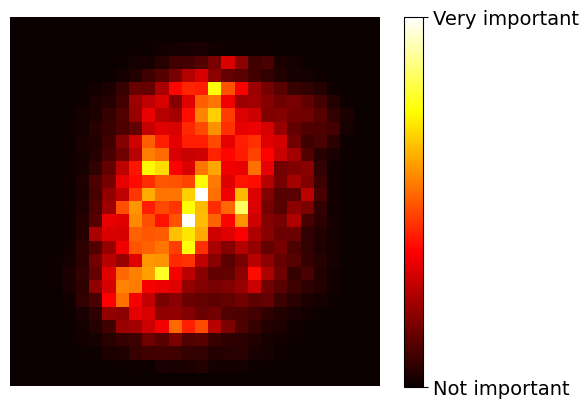

In [24]:
from sklearn.datasets import fetch_openml

X_mnist, y_mnist = fetch_openml('mnist_784', return_X_y=True, as_frame=False,
                                parser='auto')

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(X_mnist, y_mnist)

heatmap_image = rnd_clf.feature_importances_.reshape(28, 28)
plt.imshow(heatmap_image, cmap="hot")
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(),
                           rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'], fontsize=14)
plt.axis("off")
save_fig("mnist_feature_importance_plot")
plt.show()

# **Boosting**

## **AdaBoost**

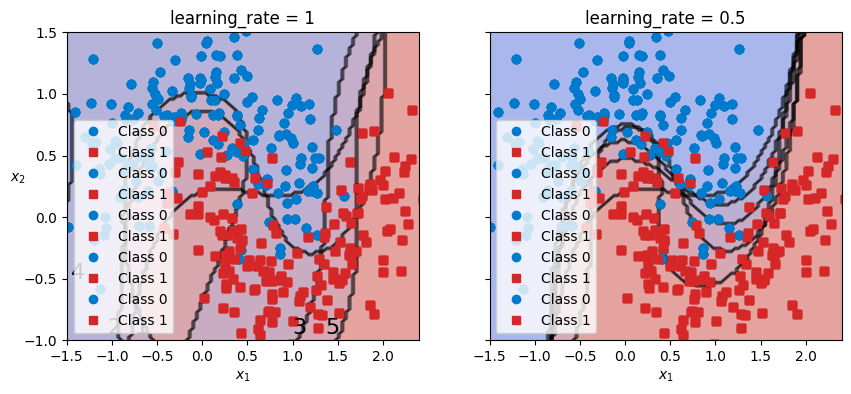

In [25]:
m = len(X_train)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        y_pred = svm_clf.predict(X_train)

        error_weights = sample_weights[y_pred != y_train].sum()
        r = error_weights / sample_weights.sum()  # equation 7-1
        alpha = learning_rate * np.log((1 - r) / r)  # equation 7-2
        sample_weights[y_pred != y_train] *= np.exp(alpha)  # equation 7-3
        sample_weights /= sample_weights.sum()  # normalization step

        plot_decision_boundary(svm_clf, X_train, y_train, alpha=0.4)
        plt.title(f"learning_rate = {learning_rate}")
    if subplot == 0:
        plt.text(-0.75, -0.95, "1", fontsize=16)
        plt.text(-1.05, -0.95, "2", fontsize=16)
        plt.text(1.0, -0.95, "3", fontsize=16)
        plt.text(-1.45, -0.5, "4", fontsize=16)
        plt.text(1.36,  -0.95, "5", fontsize=16)
    else:
        plt.ylabel("")

save_fig("boosting_plot")
plt.show()

In [29]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada_clf = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=200,
    algorithm="SAMME",  # Gunakan hanya 'SAMME'
    learning_rate=0.5
)

ada_clf.fit(X_train, y_train)


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

## **Gradient Boosting**

In [30]:
from sklearn.tree import DecisionTreeRegressor
tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2)

In [31]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2)

In [32]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2)

In [36]:
X_new = np.random.rand(100, 20)

In [37]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [38]:
from sklearn.ensemble import GradientBoostingRegressor
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3)

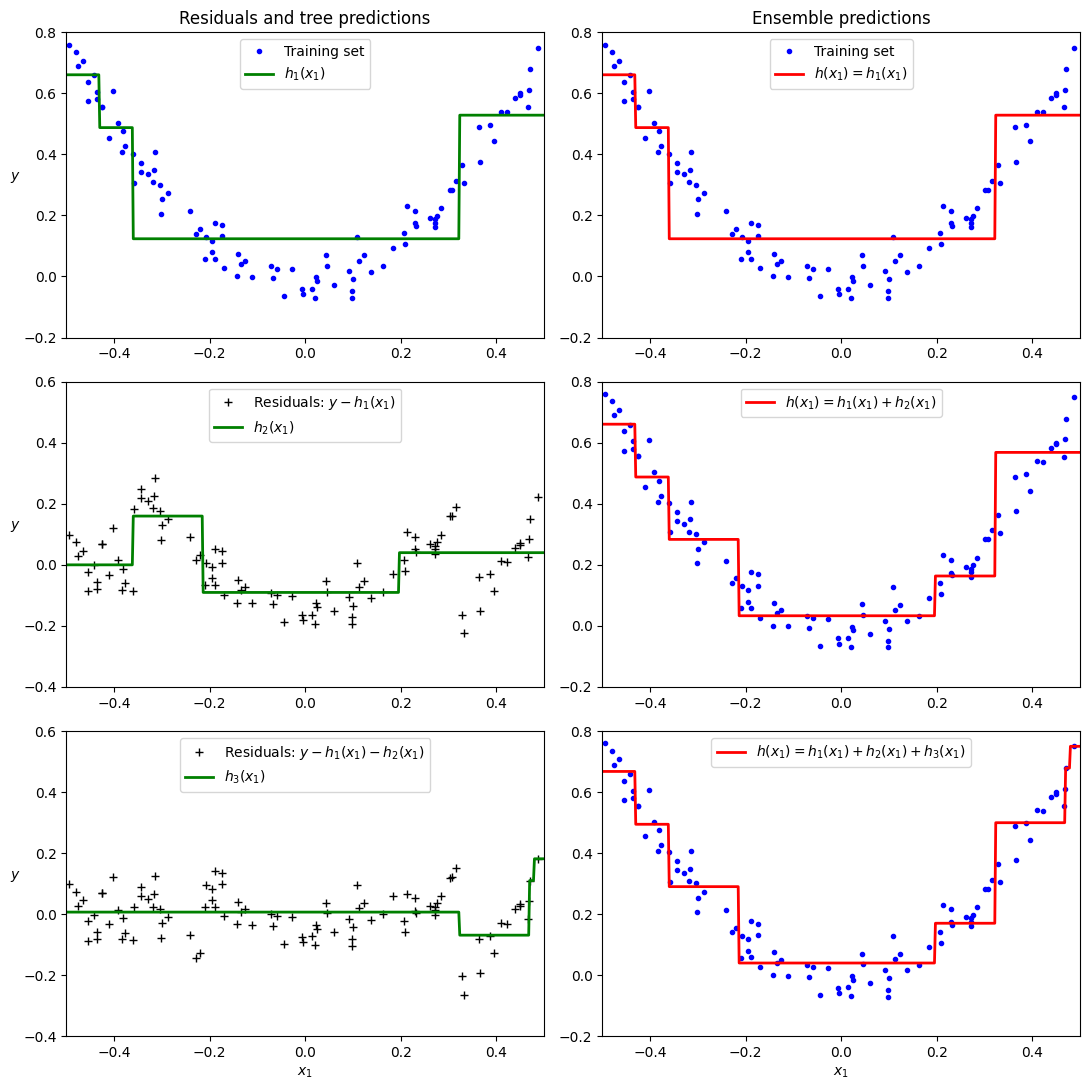

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor

# 1. Generate simple 1D training data
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5  # Shape (100, 1)
y = 3 * X[:, 0] ** 2 + 0.05 * np.random.randn(100)

# 2. Train first regressor
tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=1)
tree_reg1.fit(X, y)
y2 = y - tree_reg1.predict(X)

# 3. Train second regressor on residuals
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=2)
tree_reg2.fit(X, y2)
y3 = y2 - tree_reg2.predict(X)

# 4. Train third regressor on next residuals
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=3)
tree_reg3.fit(X, y3)

# 5. Function to plot predictions
def plot_predictions(regressors, X, y, axes, style,
                     label=None, data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = sum(regressor.predict(x1) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center")
    plt.axis(axes)

# 6. Plotting
plt.figure(figsize=(11, 11))

plt.subplot(3, 2, 1)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.2, 0.8], style="g-",
                 label="$h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$  ", rotation=0)
plt.title("Residuals and tree predictions")

plt.subplot(3, 2, 2)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.2, 0.8], style="r-",
                 label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.title("Ensemble predictions")

plt.subplot(3, 2, 3)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.4, 0.6], style="g-",
                 label="$h_2(x_1)$", data_style="k+",
                 data_label="Residuals: $y - h_1(x_1)$")
plt.ylabel("$y$  ", rotation=0)

plt.subplot(3, 2, 4)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.2, 0.8],
                  style="r-", label="$h(x_1) = h_1(x_1) + h_2(x_1)$")

plt.subplot(3, 2, 5)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.4, 0.6], style="g-",
                 label="$h_3(x_1)$", data_style="k+",
                 data_label="Residuals: $y - h_1(x_1) - h_2(x_1)$")
plt.xlabel("$x_1$")
plt.ylabel("$y$  ", rotation=0)

plt.subplot(3, 2, 6)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y,
                 axes=[-0.5, 0.5, -0.2, 0.8], style="r-",
                 label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$")

plt.tight_layout()
plt.show()


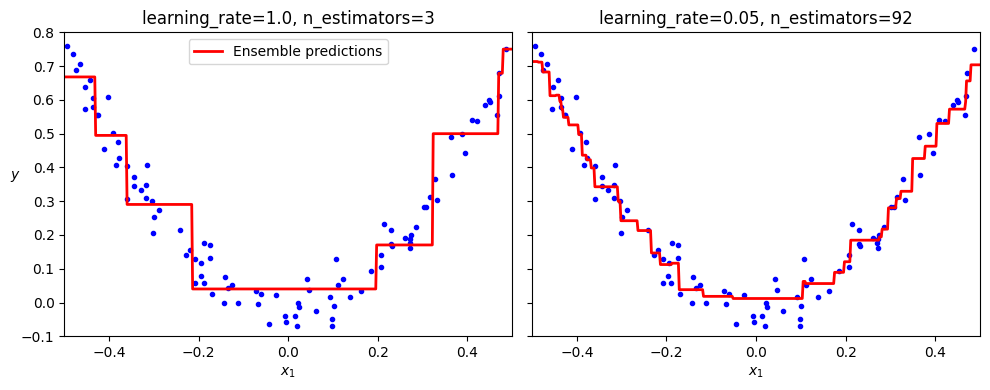

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3 * X[:, 0]**2 + 0.05 * np.random.randn(100)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=01.0, random_state=42)
gbrt.fit(X, y)

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=92,
                                      learning_rate=0.05, random_state=42)
gbrt_best.fit(X, y)

def plot_predictions(regressors, X, y, axes, style, label=None, data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = sum(regressor.predict(x1) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center")
    plt.axis(axes)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], style="r-",
                 label="Ensemble predictions")
plt.title(f"learning_rate={gbrt.learning_rate}, "
          f"n_estimators={gbrt.n_estimators_}")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8], style="r-")
plt.title(f"learning_rate={gbrt_best.learning_rate}, "
          f"n_estimators={gbrt_best.n_estimators_}")
plt.xlabel("$x_1$")

plt.tight_layout()
plt.show()


In [48]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
X_train, X_val, y_train, y_val = train_test_split(X, y)
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train, y_train)
errors = [mean_squared_error(y_val, y_pred)
for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1
gbrt_best = GradientBoostingRegressor(max_depth=2,n_estimators=bst_n_estimators)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=np.int64(80))

In [50]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)
min_val_error = float("inf")
error_going_up = 0

for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)

    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping


In [51]:
import xgboost
xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)

# **Exercise Solutions**

1. If you have trained five different models on the exact same training data, and
they all achieve 95% precision, is there any chance that you can combine these
models to get better results? If so, how? If not, why?

>  Ya, bisa dapat hasil lebih baik.Jika kelima model tersebut tidak membuat kesalahan yang sama persis, maka dengan menggabungkan prediksi mereka (misalnya lewat voting), kamu bisa: meningkatkan akurasi keseluruhan, meningkatkan stabilitas model, bahkan bisa menaikkan recall tanpa menurunkan precision terlalu jauh

2. What is the difference between hard and soft voting classifiers?

> Hard Voting	Setiap model memberikan prediksi kelas. Kelas dengan suara terbanyak menang.sedangkan Soft Voting	Setiap model memberikan probabilitas prediksi. Probabilitas rata-rata digunakan untuk memutuskan kelas. Soft voting biasanya bekerja lebih baik jika model terkalibrasi dengan baik, karena memanfaatkan confidence level.

3. Is it possible to speed up training of a bagging ensemble by distributing it across
multiple servers? What about pasting ensembles, boosting ensembles, Random
Forests, or stacking ensembles?

> Bisa Didistribusikan (Paralel Training):
* Bagging → Tiap model dilatih secara independen.
* Pasting → Sama seperti bagging, tapi tanpa pengembalian.
* Random Forest → Termasuk bagging → bisa paralel.
* Stacking → Base models bisa paralel, meta-model tidak.

4. What is the benefit of out-of-bag evaluation?

> OOB evaluation adalah teknik evaluasi internal di bagging/Random Forest:

* Setiap pohon dilatih dengan subset acak dari data (dengan replacement), jadi sekitar 37% data tidak digunakan (out-of-bag).
* Model bisa diuji pada data ini tanpa perlu validasi terpisah atau cross-validation.
* Menghemat waktu & data, dan cukup akurat.

5. What makes Extra-Trees more random than regular Random Forests? How can
this extra randomness help? Are Extra-Trees slower or faster than regular Ran‐
dom Forests?

* Extra-Trees: lebih cepat, cocok saat kecepatan penting.
* Random Forest: lebih akurat, cocok saat performa penting.

6. If your AdaBoost ensemble underfits the training data, which hyperparameters
should you tweak and how?

Jika underfitting, coba ubah:

* n_estimators → Tambah jumlah estimator (model lebih kompleks)
* learning_rate → Perbesar nilai ini agar setiap model baru memberi kontribusi lebih besar
* Base estimator (misalnya DecisionTreeClassifier) → Gunakan model dasar yang lebih kuat (misalnya tingkatkan max_depth)

7. If your Gradient Boosting ensemble overfits the training set, should you increase
or decrease the learning rate?

* Learning rate yang besar → model belajar terlalu cepat → bisa overfitting.
* Learning rate yang kecil → model belajar lebih pelan → lebih generalisasi → kurangi overfitting.

8. Load the MNIST data (introduced in Chapter 3), and split it into a training set, a
validation set, and a test set (e.g., use 50,000 instances for training, 10,000 for val‐
idation, and 10,000 for testing). Then train various classifiers, such as a Random
Forest classifier, an Extra-Trees classifier, and an SVM classifier. Next, try to com‐
bine them into an ensemble that outperforms each individual classifier on the
validation set, using soft or hard voting. Once you have found one, try it on the
test set. How much better does it perform compared to the individual classifiers?

In [67]:
# 1: Load dan split MNIST
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist.data, mnist.target.astype(int)

# Split data: 50k train, 10k val, 10k test
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=10000, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=10000, random_state=42)


In [68]:
# 2: Train classifier individu
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
et_clf = ExtraTreesClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(probability=True, kernel="rbf", C=5, gamma="scale", random_state=42)

rf_clf.fit(X_train, y_train)
et_clf.fit(X_train, y_train)
svm_clf.fit(X_train[:5000], y_train[:5000])  # SVM lebih lambat, latih hanya 5k data


SVC(C=5, probability=True, random_state=42)

In [69]:
# 3: Voting ensemble
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators=[('rf', rf_clf), ('et', et_clf), ('svm', svm_clf)],
    voting='soft'  # soft biasanya lebih baik jika model support probabilitas
)
voting_clf.fit(X_val, y_val)


VotingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                             ('et', ExtraTreesClassifier(random_state=42)),
                             ('svm',
                              SVC(C=5, probability=True, random_state=42))],
                 voting='soft')

In [ ]:
#  4: Evaluasi
from sklearn.metrics import accuracy_score

# Individual performance
print("Random Forest:", accuracy_score(y_val, rf_clf.predict(X_val)))
print("Extra Trees  :", accuracy_score(y_val, et_clf.predict(X_val)))
print("SVM          :", accuracy_score(y_val, svm_clf.predict(X_val)))

# Ensemble
print("Voting Classifier:", accuracy_score(y_val, voting_clf.predict(X_val)))


In [ ]:
# 5: Evaluasi di test set
print("Voting Classifier (test set):", accuracy_score(y_test, voting_clf.predict(X_test)))

* Random Forest dan Extra Trees biasanya dapat mencapai ~96–97% akurasi.
* SVM (dilatih terbatas) bisa mencapai ~94–96%.
* Voting ensemble seringkali meningkatkan akurasi menjadi ~97–98%, tergantung kombinasi model dan parameter.

Jadi, ensemble dengan soft voting dapat memberi peningkatan sekitar 0.5–1.5% dibanding model terbaik individu.

9. Run the individual classifiers from the previous exercise to make predictions on
the validation set, and create a new training set with the resulting predictions:
each training instance is a vector containing the set of predictions from all your
classifiers for an image, and the target is the image’s class. Train a classifier on
this new training set. Congratulations, you have just trained a blender, and
together with the classifiers it forms a stacking ensemble! Now evaluate the
ensemble on the test set. For each image in the test set, make predictions with all
your classifiers, then feed the predictions to the blender to get the ensemble’s pre‐
dictions. How does it compare to the voting classifier you trained earlier?

In [70]:
# 1: Buat prediksi pada validation set (meta-features)
# Prediksi dari masing-masing model pada validation set
val_preds_rf = rf_clf.predict(X_val)
val_preds_et = et_clf.predict(X_val)
val_preds_svm = svm_clf.predict(X_val)

# Gabungkan menjadi fitur baru (3 prediksi per gambar)
import numpy as np
X_val_blend = np.c_[
    val_preds_rf,
    val_preds_et,
    val_preds_svm
]


In [71]:
# 2: Latih blender (meta-model)
from sklearn.linear_model import LogisticRegression

blender = LogisticRegression(max_iter=1000)
blender.fit(X_val_blend, y_val)

LogisticRegression(max_iter=1000)

In [72]:
# 3: Siapkan meta-features dari test set
test_preds_rf = rf_clf.predict(X_test)
test_preds_et = et_clf.predict(X_test)
test_preds_svm = svm_clf.predict(X_test)

X_test_blend = np.c_[
    test_preds_rf,
    test_preds_et,
    test_preds_svm
]

In [73]:
# 4: Evaluasi stacking ensemble
from sklearn.metrics import accuracy_score

y_pred_blend = blender.predict(X_test_blend)
print("Stacking Ensemble Accuracy:", accuracy_score(y_test, y_pred_blend))

Stacking Ensemble Accuracy: 0.9545


In [74]:
# Perbandingan dengan Voting Classifier
voting_score = accuracy_score(y_test, voting_clf.predict(X_test))
print("Voting Classifier Accuracy :", voting_score)

Voting Classifier Accuracy : 0.9656
